In [1]:
import tensorflow as tf

available_accelerators = tf.config.list_physical_devices('GPU')

if available_accelerators:
    tf.config.set_visible_devices(available_accelerators[0], 'GPU')
    tf.config.experimental.set_memory_growth(available_accelerators[0], True)
    print("GPU acceleration enabled successfully")
else:
    print("No GPU devices detected - using CPU")

GPU acceleration enabled successfully


# 1. Setting up the Environment

---

## 1.1 Suppressing Keras' Warnings

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## 1.2 Loading the Dataset

In [3]:
import kagglehub
import os

dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

## 1.3 Importing the Necessary Libraries

In [4]:
# Standard Libraries
import os
import datetime
import itertools

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Image Processing
import cv2
from tqdm import tqdm

# TensorFlow and Keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    TensorBoard,
    LambdaCallback,
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# Scientific Computing
import scipy

# 2. Data Processing

---

## 2.1 Basic Image Processing

In [5]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

train_base_path = '/kaggle/input/brain-tumor-mri-dataset/Training'  
test_base_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'   

x_train = [] 
y_train = [] 
x_test = []
y_test = []

image_size = 224  
batch_size = 32

def process_image(image_path):
    try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.bilateralFilter(image, 9, 75, 75)  
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  
        image = cv2.resize(image, (image_size, image_size))
        return image
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

for label in labels:
    # Training data
    train_path = os.path.join(train_base_path, label)
    for file in tqdm(os.listdir(train_path)):
        image = process_image(os.path.join(train_path, file))
        if image is not None:
            x_train.append(image)
            y_train.append(labels.index(label))
    
    # Testing data
    test_path = os.path.join(test_base_path, label)
    for file in tqdm(os.listdir(test_path)):
        image = process_image(os.path.join(test_path, file))
        if image is not None:
            x_test.append(image)
            y_test.append(labels.index(label))

x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

100%|██████████| 300/300 [00:12<00:00, 24.14it/s]


Training data shape: (5712, 224, 224, 3)
Testing data shape: (1311, 224, 224, 3)


## 2.2 A Sample of Processed Images

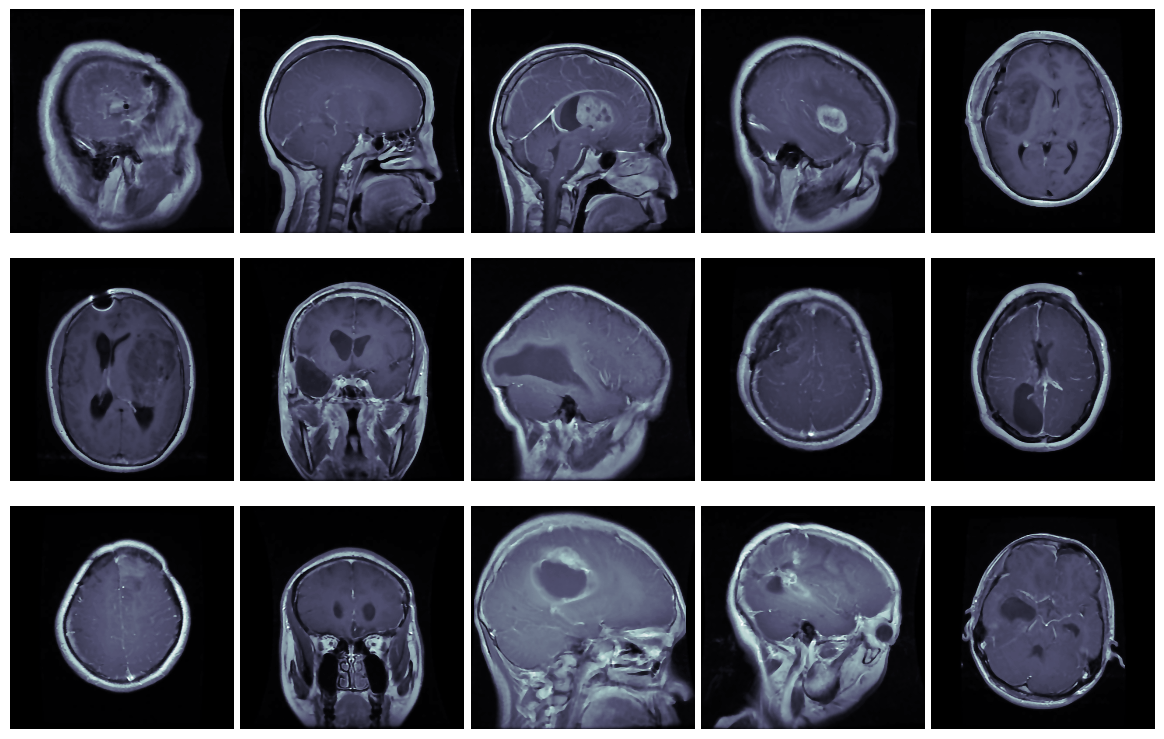

In [6]:
images = x_train[:15]

plt.figure(figsize=(12, 8))
for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(images[i][:, :, 0], cmap='bone')  
    plt.axis('off')
    plt.grid(False)

plt.tight_layout(pad=2.0, w_pad=0.5, h_pad=1.5)
plt.show()

## 2.3 Creating the Splits

In [7]:
x_train, y_train = shuffle(x_train, y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.2, 
    random_state=42
)

## 2.4 Augmenting the Data

In [8]:
datagen = ImageDataGenerator(
    rotation_range=12,        
    width_shift_range=0.07,    
    height_shift_range=0.07,      
    horizontal_flip=True,
    vertical_flip=False,   
    fill_mode='reflect'
)

datagen.fit(x_train, augment=True)

## 2.5 Making the Labels One-Hot Encoded 

In [9]:
y_train = np.argmax(y_train, axis=1)  
y_val = np.argmax(y_val, axis=1)

# 3. Building the model

---

## 3.1 Loading the Base Model

In [10]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

net = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print("Base model loaded successfully!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base model loaded successfully!


## 3.2 Enhancing the Architecture

In [11]:
x = net.output  
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)   
x = Dense(
    4, 
    kernel_regularizer=tf.keras.regularizers.L2(0.001),
    activation='softmax'
)(x)

model = Model(inputs=net.input, outputs=x)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

print("\nEnhanced Model Architecture:")
model.summary(show_trainable=True)


Enhanced Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ cast (Cast)            │ (None, 224, 224, 3)  │            0 │ input_layer[0][0]   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_pad              │ (None, 230, 230, 3)  │            0 │ cast[0][0]          │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_conv (Conv2D)    │ (None, 112, 112, 64) │        9,472 │ conv1_pad[0][0]     │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_bn               │ (None, 112, 112, 64) │          256 │ conv1_conv[0][0]    │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv1_relu             │ (None, 112, 112, 64) │            0 │ conv1_bn[0][0]      │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pad              │ (None, 114, 114, 64) │            0 │ conv1_relu[0][0]    │    -    │
│ (ZeroPadding2D)        │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ pool1_pool             │ (None, 56, 56, 64)   │            0 │ pool1_pad[0][0]     │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_conv    │ (None, 56, 56, 64)   │        4,160 │ pool1_pool[0][0]    │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_1_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_1_relu    │ (None, 56, 56, 64)   │            0 │ conv2_block1_1_bn[… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_conv    │ (None, 56, 56, 64)   │       36,928 │ conv2_block1_1_rel… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_bn      │ (None, 56, 56, 64)   │          256 │ conv2_block1_2_con… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2_block1_2_relu    │ (None, 56, 56, 64)   │            0 │ conv2_block1_2_bn[… │    -    │
│ (Activation)         

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

# 4. Setting up the TensorBoard

---

In [12]:
%load_ext tensorboard


class_names = list(labels)

def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def log_confusion_matrix(epoch, logs):
    with file_writer_cm.as_default():
        tf.summary.scalar('val_loss', logs['val_loss'], step=epoch)
        tf.summary.scalar('val_accuracy', logs['val_accuracy'], step=epoch)
    file_writer_cm.flush()

!rm -fr logs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
file_writer_cm = tf.summary.create_file_writer(logdir)

%tensorboard --logdir logs

<IPython.core.display.Javascript object>

# 5. Training the Model

---

In [13]:
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

Checkpoint = ModelCheckpoint(filepath='model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.keras',monitor='val_loss', verbose=1, save_best_only=True, mode='min')

stop = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

lr_reducer = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [
    stop,
    lr_reducer,
    tensorboard,
    Checkpoint,
    LambdaCallback(on_epoch_end=log_confusion_matrix)
]

BATCH_SIZE = 64
EPOCHS = 25

model.compile(
    optimizer=tf.keras.optimizers.AdamW(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy'
    ]
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=20),
    validation_data = (x_val,y_val),
    epochs = EPOCHS,
    callbacks = callbacks
)

Epoch 1/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7893 - loss: 0.5725
Epoch 1: val_loss improved from inf to 2.47086, saving model to model-01-0.34-2.47.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 189s 469ms/step - accuracy: 0.7898 - loss: 0.5715 - val_accuracy: 0.3395 - val_loss: 2.4709 - learning_rate: 1.0000e-04
Epoch 2/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9521 - loss: 0.1449
Epoch 2: val_loss did not improve from 2.47086
229/229 ━━━━━━━━━━━━━━━━━━━━ 50s 211ms/step - accuracy: 0.9521 - loss: 0.1449 - val_accuracy: 0.2765 - val_loss: 3.3479 - learning_rate: 1.0000e-04
Epoch 3/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9747 - loss: 0.0795
Epoch 3: val_loss did not improve from 2.47086
229/229 ━━━━━━━━━━━━━━━━━━━━ 50s 212ms/step - accuracy: 0.9747 - loss: 0.0796 - val_accuracy: 0.4156 - val_loss: 3.0022 - learning_rate: 1.0000e-04
Epoch 4/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9799 - loss: 0.0612
Epoch 4: val_loss im

# 6. Performance and Results

---

## 6.1 Plotting the Train vs Validation Accuracy Curve

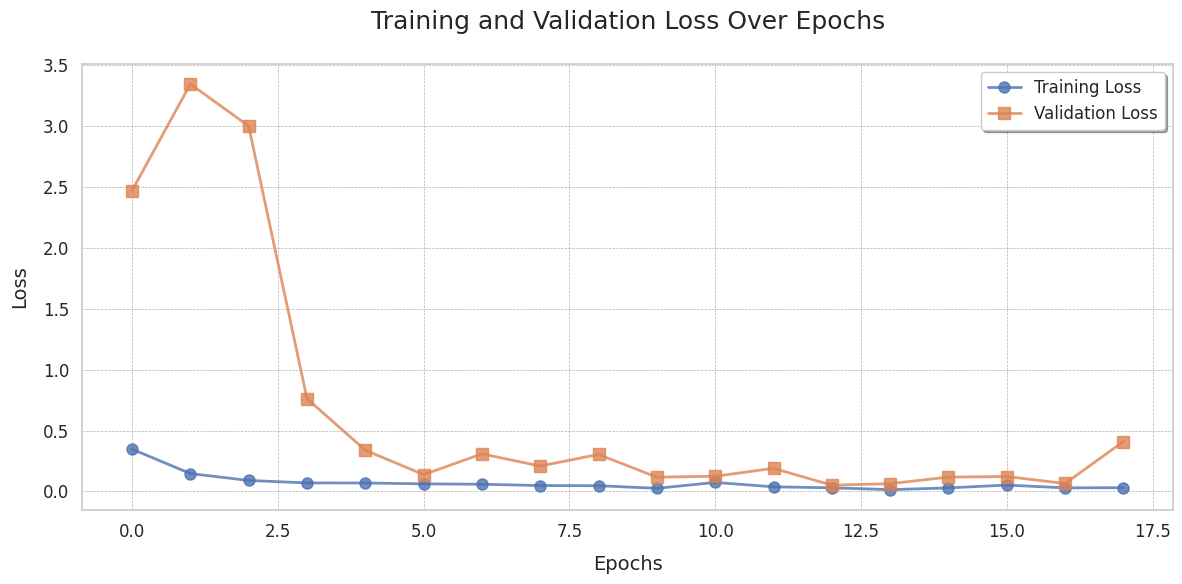

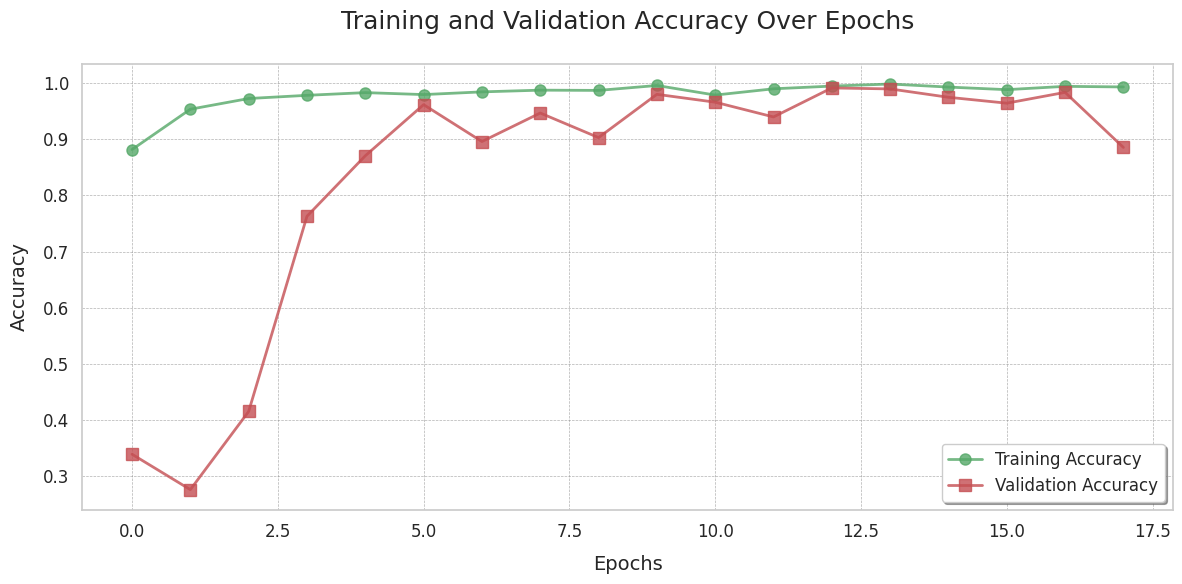

In [18]:
sns.set_theme(style='whitegrid')
sns.set_palette("muted")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='#4c72b0', linewidth=2, marker='o', markersize=8, alpha=0.8)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#dd8452', linewidth=2, marker='s', markersize=8, alpha=0.8)
plt.title('Training and Validation Loss Over Epochs', fontsize=18, pad=25)
plt.xlabel('Epochs', fontsize=14, labelpad=10)
plt.ylabel('Loss', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#55a868', linewidth=2, marker='o', markersize=8, alpha=0.8)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#c44e52', linewidth=2, marker='s', markersize=8, alpha=0.8)
plt.title('Training and Validation Accuracy Over Epochs', fontsize=18, pad=25)
plt.xlabel('Epochs', fontsize=14, labelpad=10)
plt.ylabel('Accuracy', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='lower right', frameon=True, fancybox=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## 6.2 Drawing the Confusion Matrix and Printing the Report

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


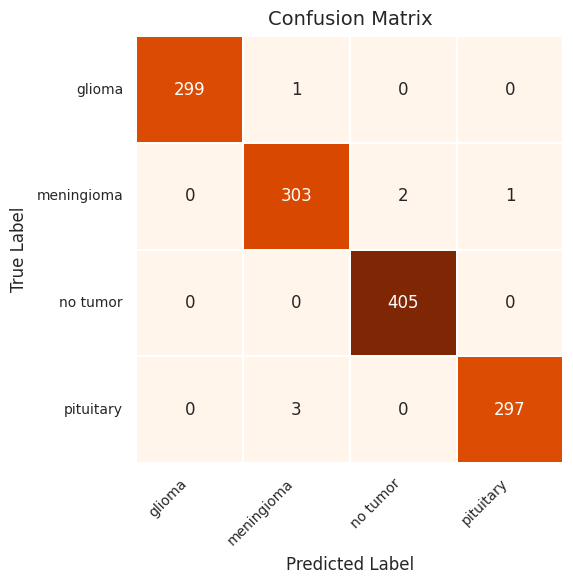


--- Classification Report ---
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      0.99      0.99       306
    no tumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [19]:
predicted_classes = np.argmax(model.predict(x_test), axis=1)

confusionmatrix = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusionmatrix, 
    annot=True, 
    fmt='d', 
    cmap='Oranges',  # Lighter warm palette
    cbar=False,  # No color bar
    square=True, 
    linewidths=0.2,  # Very subtle gridlines
    annot_kws={"size": 12},  # Moderate annotation size
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.title('Confusion Matrix', fontsize=14, pad=8)
plt.xlabel('Predicted Label', fontsize=12, labelpad=6)
plt.ylabel('True Label', fontsize=12, labelpad=6)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()

report = classification_report(
    np.argmax(y_test, axis=1), 
    predicted_classes, 
    target_names=class_labels, 
    digits=2
)
print("\n--- Classification Report ---")
print(report)